In [1]:
import os
import pandas as pd
import numpy as np
from graph_utils import (
    coverage_dayweek,
    coverage_mthyr,
    save_mpl_fig,
    its, 
    plotline, 
    plot_dual_indices
)

FP = '../data/nyt_2_textstat.csv.gz'
SAVEPATH = '../figs/'
os.makedirs(SAVEPATH, exist_ok=True) 
os.makedirs('../figs/data_coverage', exist_ok=True) 

### Data coverage

In [2]:
# (fold cell) Read & prep data
df = (pd.read_csv(FP)
      .assign(date=lambda df: pd.to_datetime(df.date, errors='coerce', utc=True))
      .groupby(['date']).size().reset_index()
      .rename(columns={0:'obs'})
      .assign(year=lambda df: [dt64.year for dt64 in df.date])
     )
df.head(3)

,date,obs,year
0,2016-12-06 00:00:00+00:00,1,2016
1,2017-06-14 00:00:00+00:00,1,2017
2,2017-06-16 00:00:00+00:00,1,2017


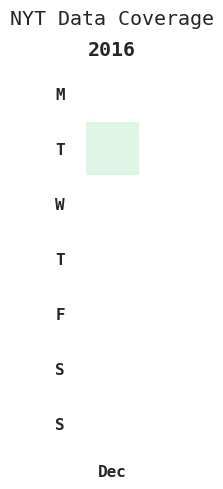

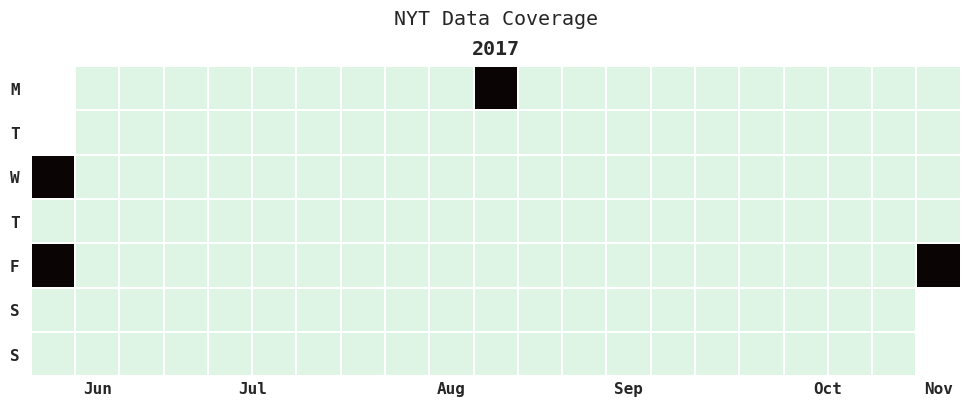

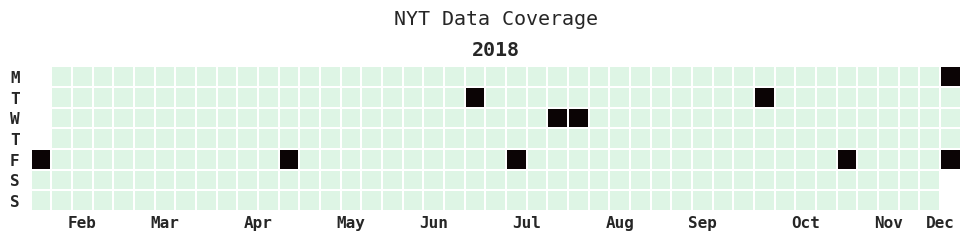

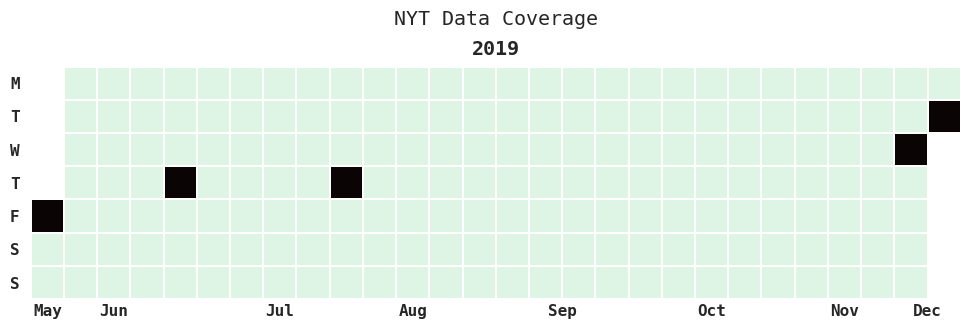

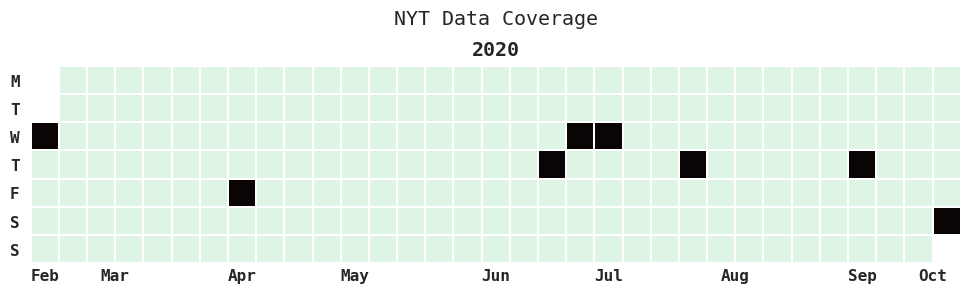

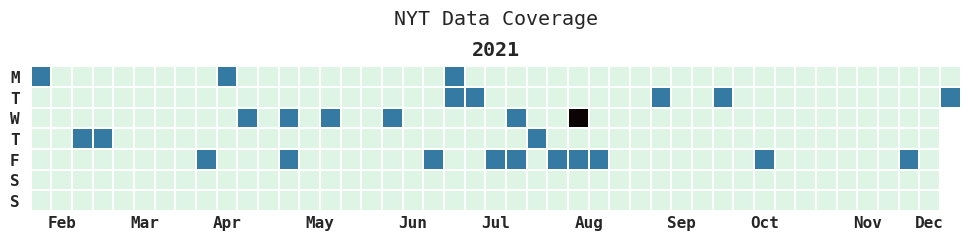

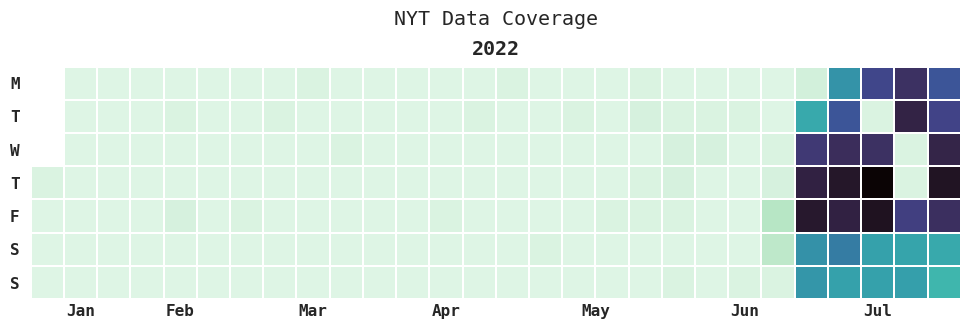

In [3]:
for year in df.year.unique():
    _df = df.query('year==@year')
    coverage_dayweek(_df.date, _df.obs, title='NYT Data Coverage')
    save_mpl_fig(os.path.join(SAVEPATH, f'data_coverage/nyt_dowmonth_{year}'))

In [4]:
# (fold cell) Read & prep data
df = (pd.read_csv(FP)
      .assign(date=lambda df: pd.to_datetime(df.date, errors='coerce', utc=True))
      .set_index('date').groupby(pd.Grouper(freq='M')).size().reset_index()
      .rename(columns={0: 'count'})
      .assign(month=lambda df: [dt64.month_name()[:3] for dt64 in df.date],
              monthix=lambda df: [dt64.month for dt64 in df.date],
              year=lambda df: [dt64.year for dt64 in df.date])
      .pivot(['month', 'monthix'], 'year', 'count')
      .sort_values('monthix').droplevel('monthix')
     )
df.head(3)

/var/folders/2y/jk8mxw2j4ds3zq99t_0t3qq80000gn/T/ipykernel_11930/4080862468.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = (pd.read_csv(FP)


year,2016,2017,2018,2019,2020,2021,2022
month,,,,,,,
Jan,NaN,0.0,0.0,0.0,0.0,0.0,1.0
Feb,NaN,0.0,1.0,0.0,1.0,2.0,3.0
Mar,NaN,0.0,0.0,0.0,0.0,1.0,4.0


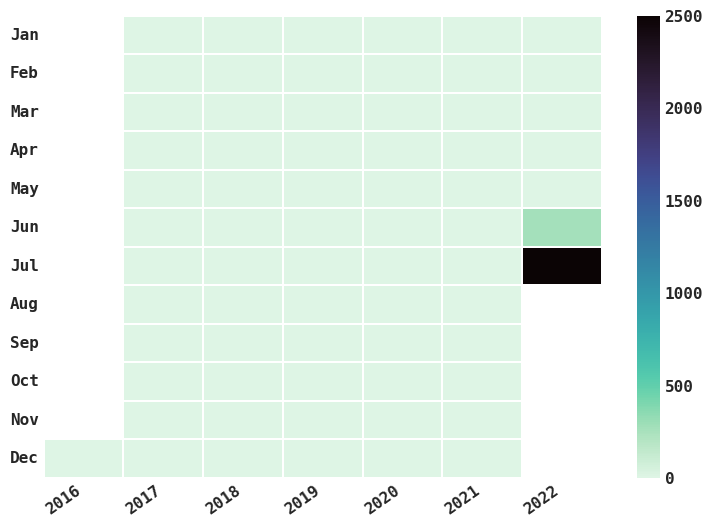

In [5]:
coverage_mthyr(df, xtickangle=35)
save_mpl_fig(os.path.join(SAVEPATH, f'data_coverage/nyt_monthyear'))

### Readability & Lexical Richness

In [11]:
# (fold cell) Read & prep data
df = (pd.read_csv(FP)
      .rename(columns={'Publication Date': 'date'})
            .assign(date=lambda df: pd.to_datetime(df.date, errors='coerce', utc=True),
              month=lambda df: [dt64.month for dt64 in df.date],
              year=lambda df: [dt64.year for dt64 in df.date],
              mthyr=lambda df: pd.to_datetime(df[['year', 'month']].assign(day=1)),
             )
      .pipe(lambda df: 
            df.query(f'terms>{df.terms.quantile(q=0.01)} & terms<{df.terms.quantile(q=0.99)}'))
      .query(f'terms>100')
      .groupby(['mthyr']).mean().reset_index())
df.head(3)

/var/folders/2y/jk8mxw2j4ds3zq99t_0t3qq80000gn/T/ipykernel_11930/3715830760.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = (pd.read_csv(FP)


,mthyr,Unnamed: 0,flesch_reading_ease,fog,smog,terms,uniqueterms,ttr,mtld,hdd,month,year
0,2016-12-01,2529.0,41.365000,NaN,19.621053,380.0,209.0,0.571038,111.449175,0.865823,12.0,2016.0
1,2017-06-01,899.5,58.525926,NaN,13.576940,248.5,139.5,0.597262,89.525057,0.832172,6.0,2017.0
2,2017-08-01,1249.0,40.940534,NaN,19.992042,382.0,197.0,0.528150,81.825700,0.843629,8.0,2017.0


In [30]:
xticklabels=range(2021, 2022, 8)

ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of ticklabels (1).

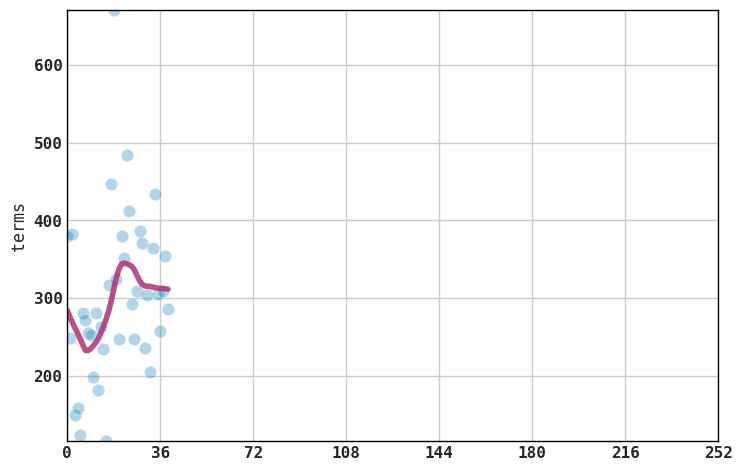

In [31]:
plotline(x=df.index, y=df.terms, yrange=range(550,750,50), title='Word Count per Article', 
         xticklabels=xticklabels,
         savepath=os.path.join(SAVEPATH, 'nyt_wordcount'))    

ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of ticklabels (1).

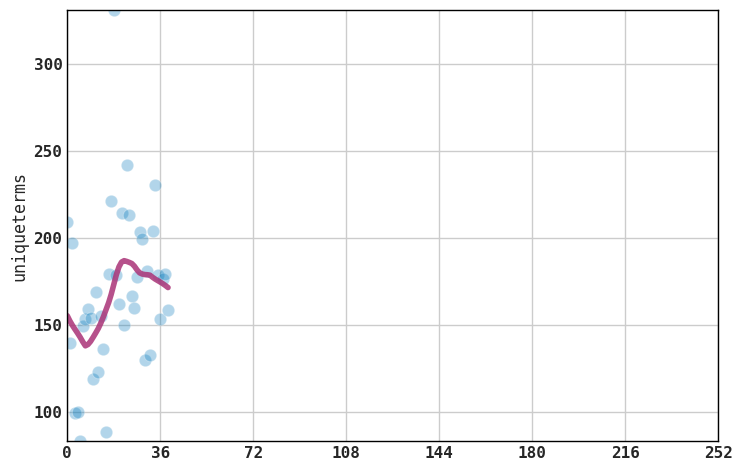

In [18]:
plotline(x=df.index, y=df.uniqueterms, yrange=range(240,340,30), title='Unique Words per Article', 
         xticklabels=xticklabels,
         savepath=os.path.join(SAVEPATH, 'nyt_uniquewords'))    

ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of ticklabels (1).

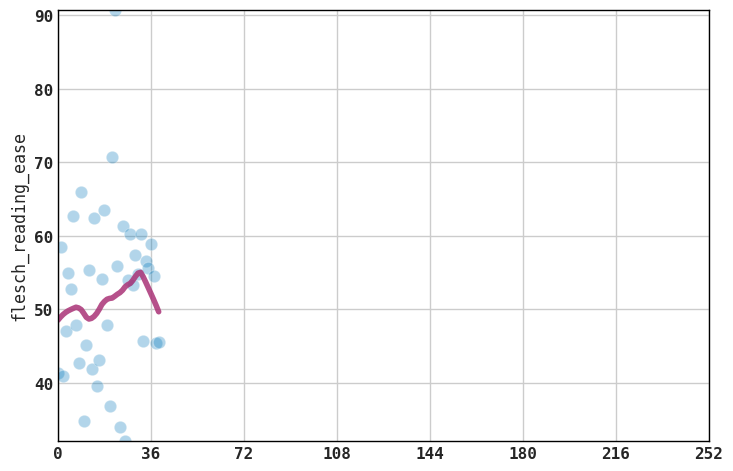

In [19]:
plotline(x=df.index, y=df.flesch_reading_ease, yrange=range(47,54,2), title='Readability (Flesch Reading Ease)',
         xticklabels=xticklabels,
         savepath=os.path.join(SAVEPATH, 'nyt_readability_flesch_ease'))    

ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of ticklabels (1).

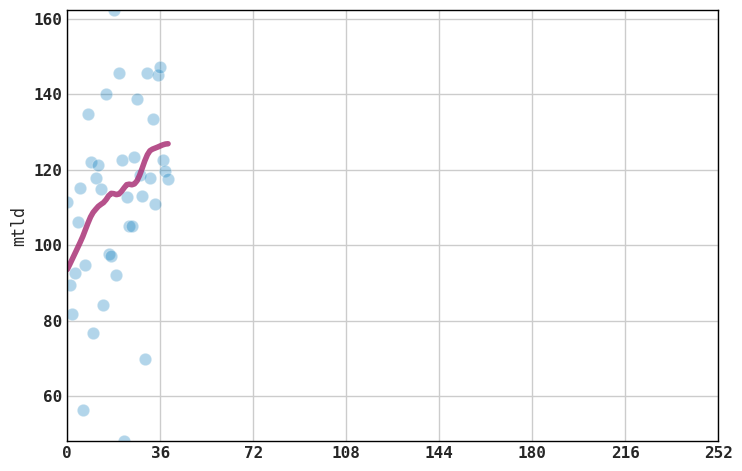

In [20]:
plotline(x=df.index, yrange=range(80,120,10), y=df.mtld, title='Lexical Richness (MTLD)', 
         xticklabels=xticklabels,
         savepath=os.path.join(SAVEPATH, 'nyt_lexicalrichness_mtld'))    

In [35]:
# (fold cell) Prep indices
idf = (pd.read_csv(FP)
       .rename(columns={'Publication Date': 'date'})
             .assign(date=lambda df: pd.to_datetime(df.date, errors='coerce', utc=True),
               month=lambda df: [dt64.month for dt64 in df.date],
               year=lambda df: [dt64.year for dt64 in df.date],
               mthyr=lambda df: pd.to_datetime(df[['year', 'month']].assign(day=1)),
              )
       # Drop outliers by length
       .pipe(lambda df: 
             df.query(f'terms>{df.terms.quantile(q=0.01)} & terms<{df.terms.quantile(q=0.99)}'))
       .query(f'terms>100')
       .groupby(['year']).mean().reset_index()
       .assign(
           iflesch_reading_ease=lambda df: df.apply(its, base=df.loc[0,'flesch_reading_ease'], x='flesch_reading_ease', axis=1),
           ismog=lambda df: df.apply(its, base=df.loc[0,'smog'], x='smog', axis=1),
           imtld=lambda df: df.apply(its, base=df.loc[0,'mtld'], x='mtld', axis=1),
           ittr=lambda df: df.apply(its, base=df.loc[0,'ttr'], x='ttr', axis=1),
           iword=lambda df: df.apply(its, base=df.loc[0,'terms'], x='terms', axis=1),
           iuniqueterms=lambda df: df.apply(its, base=df.loc[0,'uniqueterms'], x='uniqueterms', axis=1),
       )
     )
idf.head(3)

/var/folders/2y/jk8mxw2j4ds3zq99t_0t3qq80000gn/T/ipykernel_11930/4173555859.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  idf = (pd.read_csv(FP)


,year,Unnamed: 0,flesch_reading_ease,fog,smog,terms,uniqueterms,ttr,mtld,hdd,month,iflesch_reading_ease,ismog,imtld,ittr,iword,iuniqueterms
0,2016.0,2529.00,41.365000,NaN,19.621053,380.0,209.00,0.571038,111.449175,0.865823,12.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2017.0,779.75,51.264113,NaN,15.880552,257.0,143.75,0.603745,88.394836,0.842531,7.75,23.931133,-19.063711,-20.685967,5.727633,-32.368421,-31.220096
2,2018.0,896.50,49.985741,NaN,15.179351,237.5,140.80,0.626266,103.609847,0.846168,7.90,20.840665,-22.637427,-7.033994,9.671423,-37.500000,-32.631579


<AxesSubplot: xlabel='Publication year', ylabel='Percentage change from 1987'>

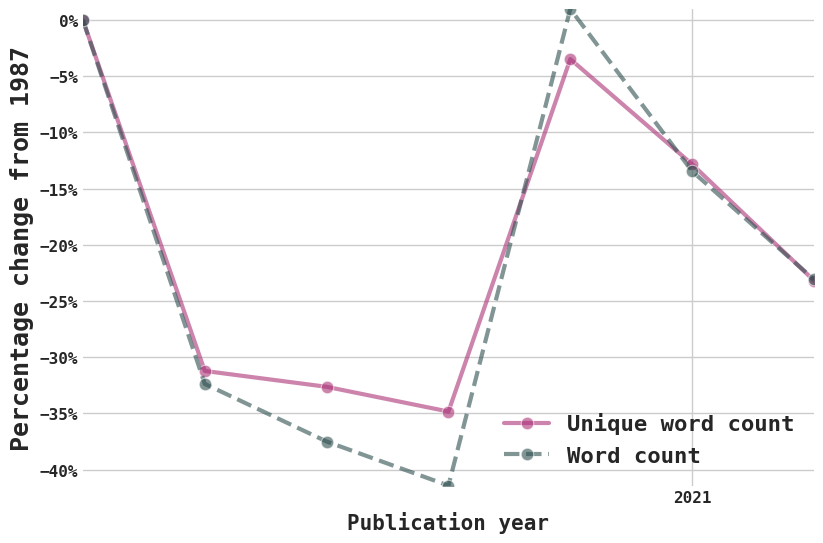

In [36]:
plot_dual_indices(x=idf.year, y1=idf.iuniqueterms, y2=idf.iword, xrange=range(2021, 2022, 3),
                  label1='Unique word count', label2='Word count', title='',
                  savepath=os.path.join(SAVEPATH, 'nyt_words_uniquewords')
                 )    

<AxesSubplot: title={'left': 'Readability'}, xlabel='Publication year', ylabel='Percentage change from 1987'>

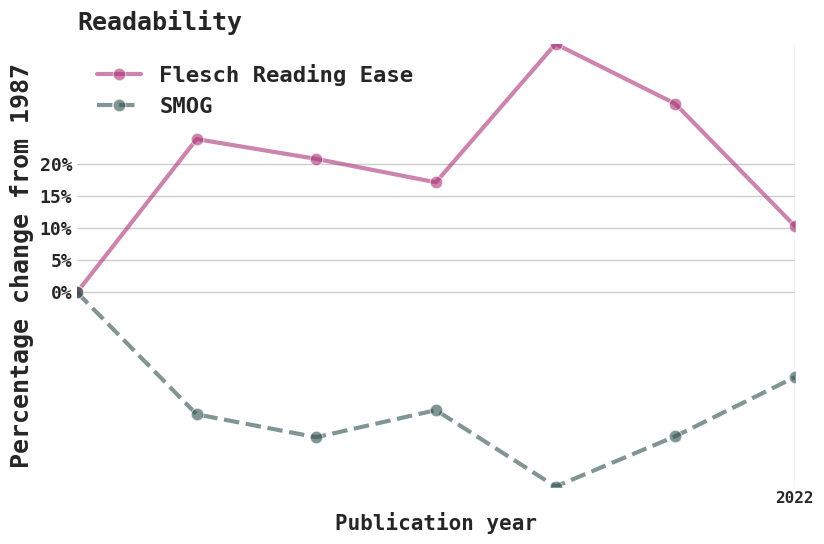

In [39]:
plot_dual_indices(x=idf.year, y1=idf.iflesch_reading_ease, y2=idf.ismog,
                  yrange=range(0,25,5), xrange=range(2022, 2023, 3), 
                  label1='Flesch Reading Ease', label2='SMOG', title='Readability',
                  savepath=os.path.join(SAVEPATH, 'nyt_readability_index'))    

<AxesSubplot: title={'left': 'Lexical Richness'}, xlabel='Publication year', ylabel='Percentage change from 1987'>

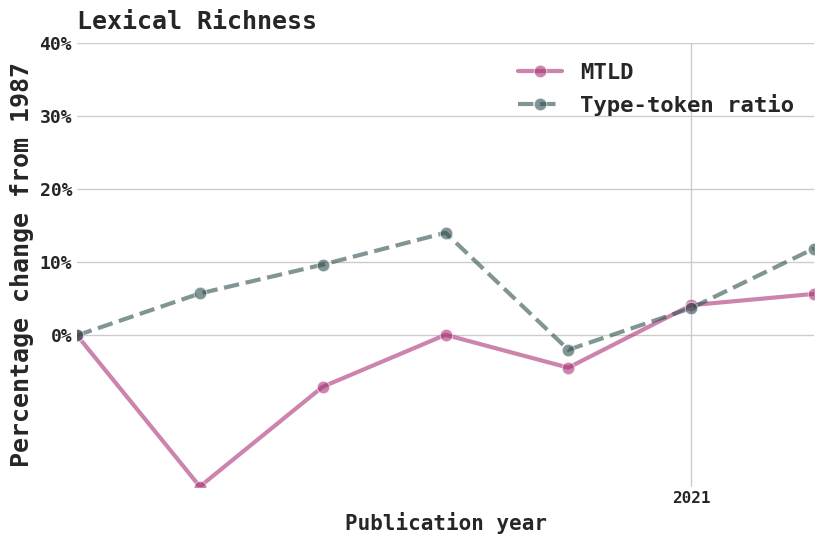

In [40]:
plot_dual_indices(x=idf.year, y1=idf.imtld, y2=idf.ittr, 
                  yrange=range(0,50,10), xrange=range(2021, 2022, 3), 
                  label1='MTLD', label2='Type-token ratio', title='Lexical Richness', 
                  savepath=os.path.join(SAVEPATH, 'nyt_lexicalrichness_index'))    